## Preparing HDFS

Using magic

Create input folder on HDFS if not exists

Copy from data from local

In [ ]:
val spark = org.apache.spark.sql.SparkSession.builder
        .master("local") 
        .appName("Spark CSV Reader")
        .getOrCreate;

In [ ]:
! pwd
! hadoop fs -mkdir -p  /tmp/rs_input
! hadoop fs -put   -p  ./../data-raw/Melbourne_housing_FULL.csv             /tmp/rs_input/raw.csv
! hadoop fs -ls        /tmp/rs_input/
!hadoop fs -cat /tmp/rs_input/raw.csv | wc -l

In [13]:
//load raw into df
val df_raw = spark
    .read
    .format("csv")
    .option("header", "true")
    .load("hdfs://localhost:9000/tmp/rs_input/raw.csv")

df_raw: org.apache.spark.sql.DataFrame = [Suburb: string, Address: string ... 19 more fields]


### Data Exploration

In [14]:
val df_raw = spark.read.format("csv").option("header", "true").load("hdfs://localhost:9000/tmp/rs_input/raw.csv")

df_raw: org.apache.spark.sql.DataFrame = [Suburb: string, Address: string ... 19 more fields]


## Analysis

### Print schema:

In [15]:
df_raw.printSchema()

root
 |-- Suburb: string (nullable = true)
 |-- Address: string (nullable = true)
 |-- Rooms: string (nullable = true)
 |-- Type: string (nullable = true)
 |-- Price: string (nullable = true)
 |-- Method: string (nullable = true)
 |-- SellerG: string (nullable = true)
 |-- Date: string (nullable = true)
 |-- Distance: string (nullable = true)
 |-- Postcode: string (nullable = true)
 |-- Bedroom2: string (nullable = true)
 |-- Bathroom: string (nullable = true)
 |-- Car: string (nullable = true)
 |-- Landsize: string (nullable = true)
 |-- BuildingArea: string (nullable = true)
 |-- YearBuilt: string (nullable = true)
 |-- CouncilArea: string (nullable = true)
 |-- Lattitude: string (nullable = true)
 |-- Longtitude: string (nullable = true)
 |-- Regionname: string (nullable = true)
 |-- Propertycount: string (nullable = true)



In [16]:
df_raw.columns

res6: Array[String] = Array(Suburb, Address, Rooms, Type, Price, Method, SellerG, Date, Distance, Postcode, Bedroom2, Bathroom, Car, Landsize, BuildingArea, YearBuilt, CouncilArea, Lattitude, Longtitude, Regionname, Propertycount)


### Show column types:

In [17]:
df_raw.dtypes

res7: Array[(String, String)] = Array((Suburb,StringType), (Address,StringType), (Rooms,StringType), (Type,StringType), (Price,StringType), (Method,StringType), (SellerG,StringType), (Date,StringType), (Distance,StringType), (Postcode,StringType), (Bedroom2,StringType), (Bathroom,StringType), (Car,StringType), (Landsize,StringType), (BuildingArea,StringType), (YearBuilt,StringType), (CouncilArea,StringType), (Lattitude,StringType), (Longtitude,StringType), (Regionname,StringType), (Propertycount,StringType))


All features seem to be stored as text therefore numerical values will need to be converted to Integer and Float accordingly.
In addition, the categorical variables of Type and Method will need to be converted to integers as factors.

## Display the rows:

In [18]:
df_raw.select("Suburb","Address","POSTCODE","SUBURB","TYPE","METHOD","SELLERG","DATE","COUNCILAREA","REGIONNAME","YEARBUILT").show()

+----------+-------------------+--------+----------+----+------+-------+---------+------------------+--------------------+---------+
|    Suburb|            Address|POSTCODE|    SUBURB|TYPE|METHOD|SELLERG|     DATE|       COUNCILAREA|          REGIONNAME|YEARBUILT|
+----------+-------------------+--------+----------+----+------+-------+---------+------------------+--------------------+---------+
|Abbotsford|      68 Studley St|    3067|Abbotsford|   h|    SS| Jellis|3/09/2016|Yarra City Council|Northern Metropol...|     null|
|Abbotsford|       85 Turner St|    3067|Abbotsford|   h|     S| Biggin|3/12/2016|Yarra City Council|Northern Metropol...|     null|
|Abbotsford|    25 Bloomburg St|    3067|Abbotsford|   h|     S| Biggin|4/02/2016|Yarra City Council|Northern Metropol...|     1900|
|Abbotsford| 18/659 Victoria St|    3067|Abbotsford|   u|    VB| Rounds|4/02/2016|Yarra City Council|Northern Metropol...|     null|
|Abbotsford|       5 Charles St|    3067|Abbotsford|   h|    SP| Bigg

In [19]:
df_raw.select("Landsize","BuildingArea","YearBuilt","CouncilArea","Lattitude","Longtitude","Regionname","Propertycount").show(10)

+--------+------------+---------+------------------+---------+----------+--------------------+-------------+
|Landsize|BuildingArea|YearBuilt|       CouncilArea|Lattitude|Longtitude|          Regionname|Propertycount|
+--------+------------+---------+------------------+---------+----------+--------------------+-------------+
|     126|        null|     null|Yarra City Council| -37.8014|  144.9958|Northern Metropol...|         4019|
|     202|        null|     null|Yarra City Council| -37.7996|  144.9984|Northern Metropol...|         4019|
|     156|          79|     1900|Yarra City Council| -37.8079|  144.9934|Northern Metropol...|         4019|
|       0|        null|     null|Yarra City Council| -37.8114|  145.0116|Northern Metropol...|         4019|
|     134|         150|     1900|Yarra City Council| -37.8093|  144.9944|Northern Metropol...|         4019|
|      94|        null|     null|Yarra City Council| -37.7969|  144.9969|Northern Metropol...|         4019|
|     120|         

The data seems to be relatively clean however there are many nulls and further exploration is required.

## EDA using python


#### Change type of columns "Price", "DistanceFromCBD" & "Landsize" to Double, "Rooms", "Bathroom", "Car" to Int

In [20]:
var df_anl = df_raw.withColumnRenamed("Method","MethodOfSale")
    .withColumnRenamed("Distance","DistanceFromCBD")
    .withColumnRenamed("Type","PropertyType")
    .withColumnRenamed("Lattitude","Latitude")
    

df_anl: org.apache.spark.sql.DataFrame = [Suburb: string, Address: string ... 19 more fields]


In [21]:
df_anl = df_anl.withColumn("Price",col("Price").cast("Double"))
    .withColumn("Rooms",col("Rooms").cast("Int"))
    .withColumn("DistanceFromCBD",col("DistanceFromCBD").cast("Double"))
    .withColumn("Bathroom",col("Bathroom").cast("Int"))
    .withColumn("Car",col("Car").cast("Int"))
    .withColumn("Landsize",col("Landsize").cast("Double"))
    .withColumn("Latitude",col("Latitude").cast("String"))
    .withColumn("Longtitude",col("Longtitude").cast("String"))
 

df_anl: org.apache.spark.sql.DataFrame = [Suburb: string, Address: string ... 19 more fields]


In [22]:
//convert categorically values to ints
//make sure the categorical type is upper
df_anl = df_anl.withColumn("PropertyType", upper(col("PropertyType")))

df_anl = df_anl.withColumn("PropertyType",
when(col("PropertyType") === "H", "1")
.when(col("PropertyType") === "U", "2")
.when(col("PropertyType") ==="T", "3")
.otherwise("0"))

df_anl: org.apache.spark.sql.DataFrame = [Suburb: string, Address: string ... 19 more fields]
df_anl: org.apache.spark.sql.DataFrame = [Suburb: string, Address: string ... 19 more fields]


In [24]:
//convert categorically values to ints
//make sure the categorical type is upper
df_anl = df_anl.withColumn("MethodOfSale", upper(col("MethodOfSale")))

df_anl: org.apache.spark.sql.DataFrame = [Suburb: string, Address: string ... 19 more fields]


In [25]:
df_anl = df_anl.withColumn("MethodOfSale",
when(col("MethodOfSale") === "S", "1")
.when(col("MethodOfSale") === "SP", "2")
.when(col("MethodOfSale") === "PI", "3")
.when(col("MethodOfSale") === "PN", "4")
.when(col("MethodOfSale") === "SN", "5")
.when(col("MethodOfSale") === "VB", "6")
.when(col("MethodOfSale") === "W", "7")
.when(col("MethodOfSale") === "SA", "8")
.when(col("MethodOfSale") === "SS", "9")                                
.otherwise("0"))

df_anl: org.apache.spark.sql.DataFrame = [Suburb: string, Address: string ... 19 more fields]


Share a dataset by registering it as a view. 

In [26]:
df_anl.toDF.createOrReplaceTempView("df_py_raw")

In [27]:
%%python
df_raw_p = spark.sql("select * from df_py_raw")


In [28]:
! pip install matplotlib
! pip install pandas
%%python
import pandas as pd
df_raw_pd = df_raw_p.toPandas() 
print(df_raw_pd.columns)
print(df_raw_pd.head())

























Index(['Suburb', 'Address', 'Rooms', 'PropertyType', 'Price', 'MethodOfSale',
       'SellerG', 'Date', 'DistanceFromCBD', 'Postcode', 'Bedroom2',
       'Bathroom', 'Car', 'Landsize', 'BuildingArea', 'YearBuilt',
       'CouncilArea', 'Latitude', 'Longtitude', 'Regionname', 'Propertycount'],
      dtype='object')
       Suburb             Address  ...             Regionname Propertycount
0  Abbotsford       68 Studley St  ...  Northern Metropolitan          4019
1  Abbotsford        85 Turner St  ...  Northern Metropolitan          4019
2  Abbotsford     25 Bloomburg St  ...  Northern Metropolitan          4019
3  Abbotsford  18/659 Victoria St  ...  Northern Metropolitan          4019
4  Abbotsford        5 Charles St  ...  Northern Metropolitan          4019

[5 rows x 21 columns]


### Price Frequency Distribution

<IPython.core.display.Javascript object>


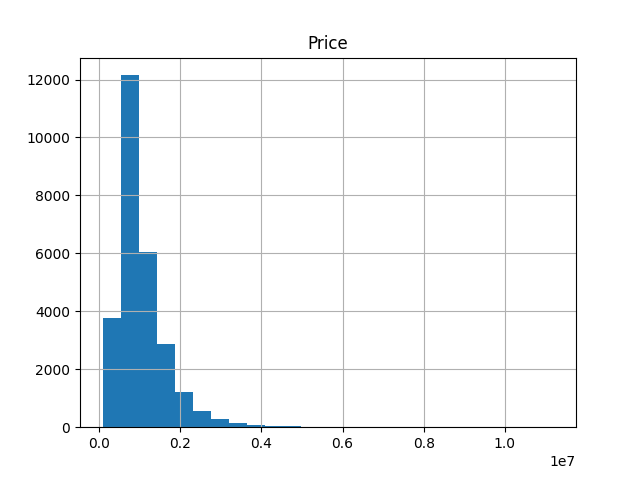

In [29]:
%matplotlib notebook 
%%python
from matplotlib import pyplot as plt
import pandas as pd

df_raw_pd.hist(column = 'Price',bins=25)
plt.show()

### Property Type Frequency Distribution

<IPython.core.display.Javascript object>


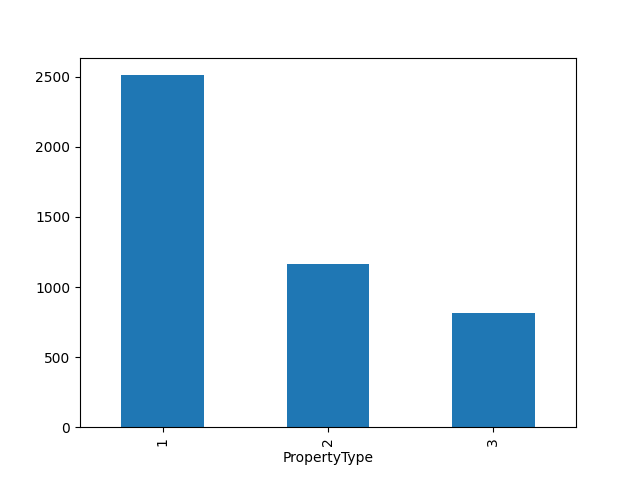

In [31]:
%matplotlib notebook 
%%python
from matplotlib import pyplot as plt
import pandas as pd

# 1 -House, 2- Unit, 3 -Townhouse
df_raw_pd.groupby("PropertyType")["Price"].nunique().plot(kind='bar')
plt.show()

### Rooms Frequency Distribution

<IPython.core.display.Javascript object>


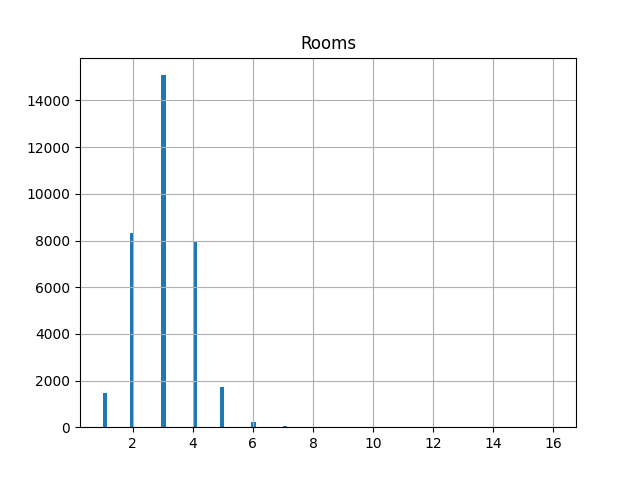

In [32]:
%matplotlib notebook 
%%python
from matplotlib import pyplot as plt
import pandas as pd

df_raw_pd.hist(column = 'Rooms',bins=100)
plt.show()

### Bathroom Frequency Distribution

<IPython.core.display.Javascript object>


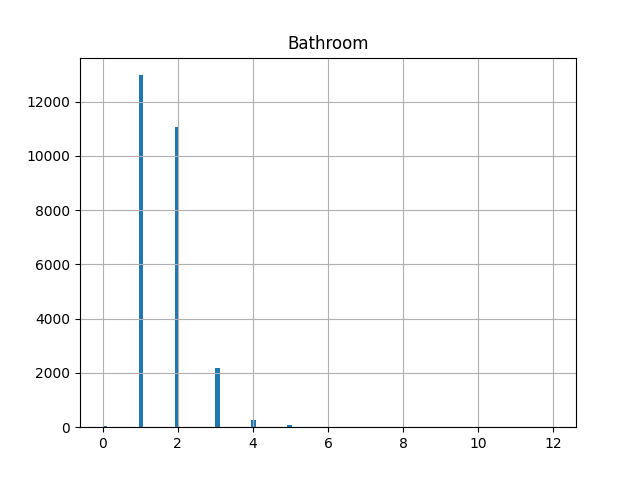

In [33]:
%matplotlib notebook 
%%python
from matplotlib import pyplot as plt
import pandas as pd

df_raw_pd.hist(column = 'Bathroom',bins=100)
plt.show()

### Price Distance Scatterplot

<IPython.core.display.Javascript object>


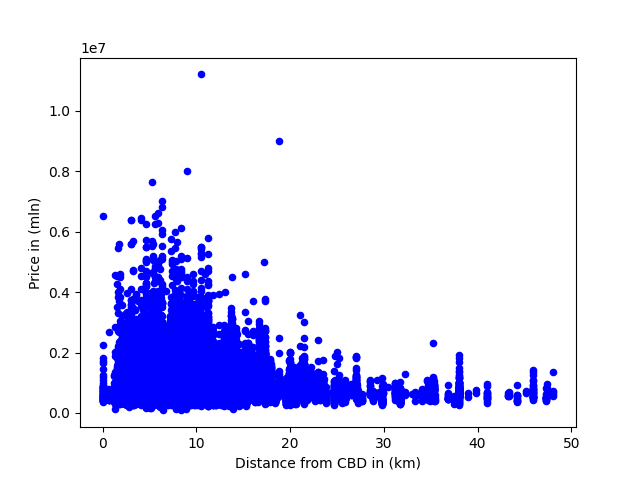

In [34]:
%matplotlib notebook 
%%python
from matplotlib import pyplot as plt
import pandas as pd

ax = df_raw_pd.plot(kind='scatter',x='DistanceFromCBD',y='Price',color='blue')
ax.set_ylabel('Price in (mln)')
ax.set_xlabel('Distance from CBD in (km)')

plt.show()



### Price Number of Rooms  Scatterplot

<IPython.core.display.Javascript object>


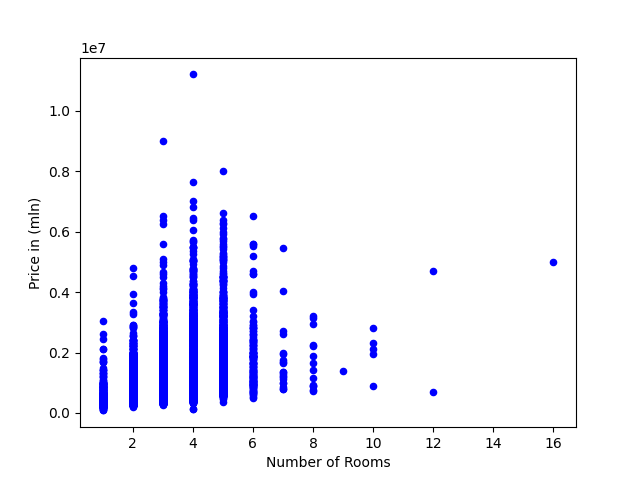

In [35]:
%matplotlib notebook 
%%python
from matplotlib import pyplot as plt
import pandas as pd

ax = df_raw_pd.plot(kind='scatter',x='Rooms',y='Price',color='blue')
ax.set_ylabel('Price in (mln)')
ax.set_xlabel('Number of Rooms')

plt.show()



### Price Number of Bathrooms  Scatterplot

<IPython.core.display.Javascript object>


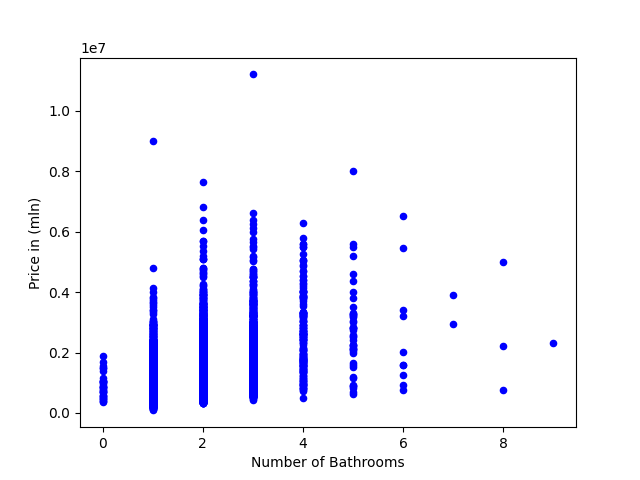

In [36]:
%matplotlib notebook 
%%python
from matplotlib import pyplot as plt
import pandas as pd

ax = df_raw_pd.plot(kind='scatter',x='Bathroom',y='Price',color='blue')
ax.set_ylabel('Price in (mln)')
ax.set_xlabel('Number of Bathrooms')

plt.show()



### Price Number of Cars  Scatterplot


<IPython.core.display.Javascript object>


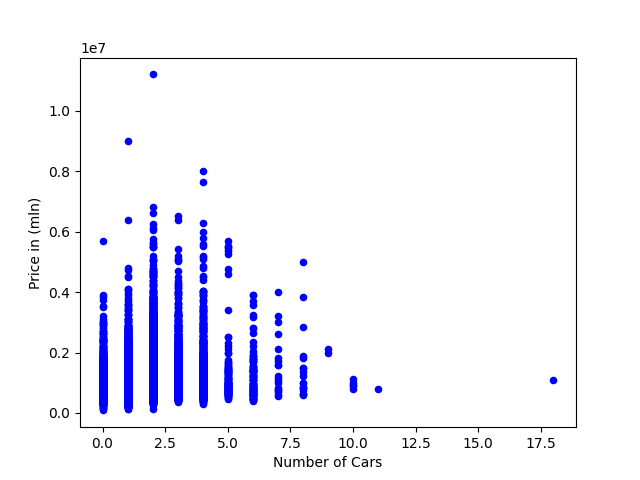

In [37]:
%matplotlib notebook 
%%python
from matplotlib import pyplot as plt
import pandas as pd

ax = df_raw_pd.plot(kind='scatter',x='Car',y='Price',color='blue')
ax.set_ylabel('Price in (mln)')
ax.set_xlabel('Number of Cars')

plt.show()

### Price Land Size Scatterplot

<IPython.core.display.Javascript object>


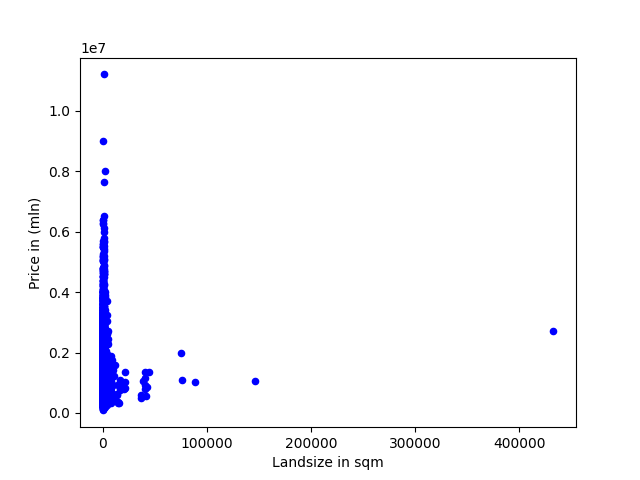

In [38]:
%matplotlib notebook 
%%python
from matplotlib import pyplot as plt
import pandas as pd

ax = df_raw_pd.plot(kind='scatter',x='Landsize',y='Price',color='blue')
ax.set_ylabel('Price in (mln)')
ax.set_xlabel('Landsize in sqm')

plt.show()


### Price Building Area  Scatterplot

In [64]:
# number of null values
%%python
df_raw_pd.BuildingArea.isna().sum().sum()


21115

<IPython.core.display.Javascript object>


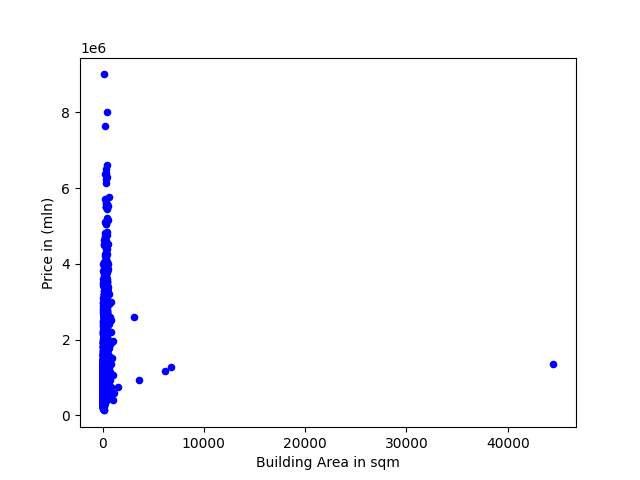

In [50]:
%matplotlib notebook 
%%python
from matplotlib import pyplot as plt
import pandas as pd

ax = df_raw_pd.plot(kind='scatter',x='BuildingArea',y='Price',color='blue')
ax.set_ylabel('Price in (mln)')
ax.set_xlabel('Building Area in sqm')

plt.show()


### Price Property Count Scatterplot


<IPython.core.display.Javascript object>


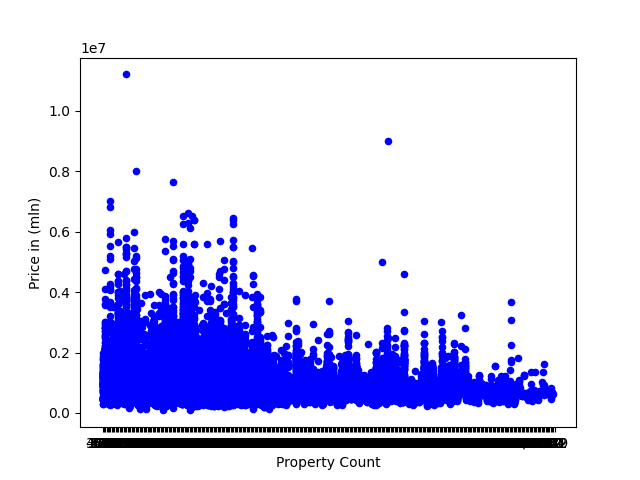

In [53]:
%matplotlib notebook 
%%python
from matplotlib import pyplot as plt
import pandas as pd

ax = df_raw_pd.plot(kind='scatter',x='Propertycount',y='Price',color='blue')
ax.set_ylabel('Price in (mln)')
ax.set_xlabel('Property Count')

plt.show()


### Year Built

In [65]:
%%python
df_raw_pd.YearBuilt.isna().sum().sum()

19306

<IPython.core.display.Javascript object>


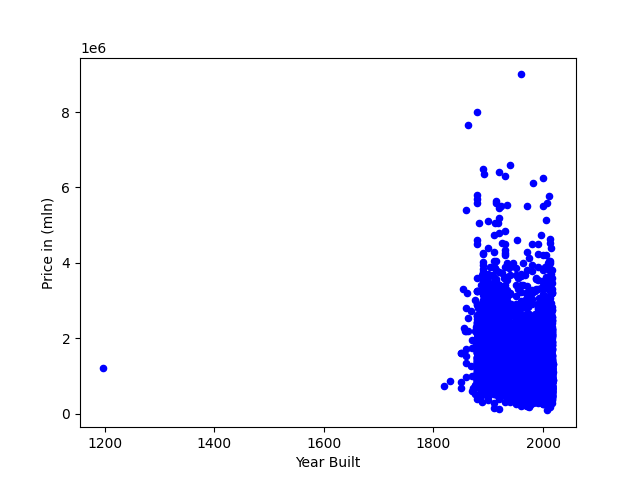

In [118]:
%matplotlib notebook 
%%python
from matplotlib import pyplot as plt
import pandas as pd

ax = df_raw_pd.plot(kind='scatter',x='YearBuilt',y='Price',color='blue')
ax.set_ylabel('Price in (mln)')
ax.set_xlabel('Year Built')

plt.show()



### We found an outlier!

In [119]:
val df_temp = df_anl.withColumn("YearBuilt",col("YearBuilt").cast("Int"))
df_temp.describe().select("Price", "YearBuilt").show()
df_temp.filter($"YearBuilt"<1800).select("Price", "YearBuilt").show()



+-----------------+------------------+
|            Price|         YearBuilt|
+-----------------+------------------+
|            27247|             15551|
|1050173.344955408| 1965.289884894862|
|641467.1301045999|37.328178023136616|
|          85000.0|              1196|
|           1.12E7|              2106|
+-----------------+------------------+

+---------+---------+
|    Price|YearBuilt|
+---------+---------+
|1200000.0|     1196|
+---------+---------+



df_temp: org.apache.spark.sql.DataFrame = [Suburb: string, Address: string ... 19 more fields]


### Detection of Outliers

<IPython.core.display.Javascript object>


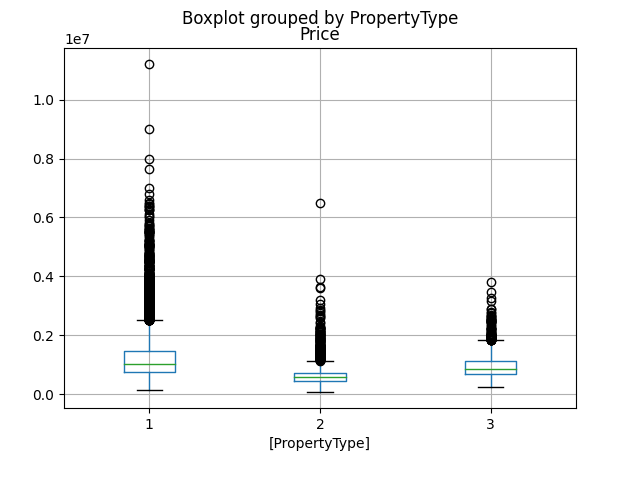

In [120]:
%matplotlib notebook 
%%python
from matplotlib import pyplot as plt
import pandas as pd

df_raw_pd[["Price","PropertyType"]].boxplot( by="PropertyType", return_type='axes')
plt.show()

<IPython.core.display.Javascript object>


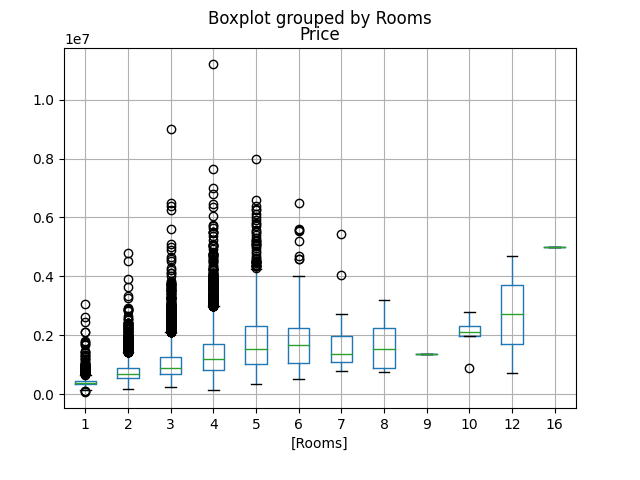

In [121]:
%matplotlib notebook 
%%python
from matplotlib import pyplot as plt
import pandas as pd

df_raw_pd[["Price","Rooms"]].boxplot( by="Rooms", return_type='axes')
plt.show()

## Descriptive Statistics:

### Summary

In [122]:
df_raw.describe().select("summary",
                        "Suburb",
                        "Address",
                        "Rooms",
                        "Type",
                        "Price",
                        "Method",
                        "SellerG",
                        "Date").show()

+-------+----------+----------------+------------------+-----+-----------------+------+-----------+---------+
|summary|    Suburb|         Address|             Rooms| Type|            Price|Method|    SellerG|     Date|
+-------+----------+----------------+------------------+-----+-----------------+------+-----------+---------+
|  count|     34857|           34857|             34857|34857|            27247| 34857|      34857|    34857|
|   mean|      null|            null|3.0310124221820582| null|1050173.344955408|  null|       null|     null|
| stddev|      null|            null|0.9699329348975204| null|641467.1301045999|  null|       null|     null|
|    min|Abbotsford|1 Abercrombie St|                 1|    h|          1000000|    PI|    @Realty|1/07/2017|
|    max|  viewbank|   9b Stewart St|                 9|    u|           999999|     W|voglwalpole|9/12/2017|
+-------+----------+----------------+------------------+-----+-----------------+------+-----------+---------+



In [123]:
df_raw.describe().select("summary",
                        "Distance",
                        "Postcode",
                        "Bedroom2",
                        "Bathroom",
                        "Car",
                        "Landsize").show()

+-------+------------------+------------------+------------------+------------------+------------------+------------------+
|summary|          Distance|          Postcode|          Bedroom2|          Bathroom|               Car|          Landsize|
+-------+------------------+------------------+------------------+------------------+------------------+------------------+
|  count|             34857|             34857|             26640|             26631|             26129|             23047|
|   mean|11.184929423916007| 3116.062858618315|3.0846471471471473| 1.624798167549097|1.7288453442535114|  593.598993361392|
| stddev| 6.788892455935938|109.02390274290613|0.9806897285461588|0.7242120114699068|1.0107707853554244|3398.8419464599056|
|    min|              #N/A|              #N/A|                 0|                 0|                 0|                 0|
|    max|               9.9|              3978|                 9|                 9|                 9|               999|
+-------

In [124]:
df_raw.describe().select("summary",
                        "BuildingArea",
                        "YearBuilt",
                        "CouncilArea",
                        "Lattitude",
                        "Longtitude",
                        "Regionname").show()

+-------+------------------+------------------+--------------------+-------------------+-------------------+----------------+
|summary|      BuildingArea|         YearBuilt|         CouncilArea|          Lattitude|         Longtitude|      Regionname|
+-------+------------------+------------------+--------------------+-------------------+-------------------+----------------+
|  count|             13742|             15551|               34857|              26881|              26881|           34857|
|   mean| 160.2564003565711| 1965.289884894862|                null|-37.810634295599094| 145.00185113165438|            null|
| stddev|401.26706008485496|37.328178023136616|                null| 0.0902789045092229|0.12016876915353476|            null|
|    min|                 0|              1196|                #N/A|           -37.3902|          144.42379|            #N/A|
|    max|               999|              2106|Yarra Ranges Shir...|          -38.19043|          145.52635|Western Vi

In [125]:
df_raw.describe().select("summary",
                         "Propertycount").show()

+-------+------------------+
|summary|     Propertycount|
+-------+------------------+
|  count|             34857|
|   mean|7572.8883055029555|
| stddev|4428.0903132746425|
|    min|              #N/A|
|    max|               984|
+-------+------------------+



Based on the above summary statistics we can see the following:
* The count of a column less the rows in the dataset, display the null values.
* The Address will need to be stripped down to its Street Name and Street Type. This is to  

### Correlation:

Assess the correlation between the Price and the other features to better understand their relationship and importance.

In [126]:
// Import Correlation Library
import org.apache.spark.sql.functions.corr

import org.apache.spark.sql.functions.corr


In [127]:
df_raw.select(corr("Rooms","Price")).show()
df_raw.select(corr("Distance","Price")).show()
df_raw.select(corr("Postcode","Price")).show()
df_raw.select(corr("Bedroom2","Price")).show()
df_raw.select(corr("Bathroom","Price")).show()
df_raw.select(corr("Car","Price")).show()
df_raw.select(corr("Landsize","Price")).show()
df_raw.select(corr("BuildingArea","Price")).show()
df_raw.select(corr("YearBuilt","Price")).show()
df_raw.select(corr("Lattitude","Price")).show()
df_raw.select(corr("Longtitude","Price")).show()
df_raw.select(corr("Propertycount","Price")).show()

+-------------------+
| corr(Rooms, Price)|
+-------------------+
|0.46523834510759615|
+-------------------+

+---------------------+
|corr(Distance, Price)|
+---------------------+
| -0.21138434279157942|
+---------------------+

+---------------------+
|corr(Postcode, Price)|
+---------------------+
|  0.04494983007693704|
+---------------------+

+---------------------+
|corr(Bedroom2, Price)|
+---------------------+
|   0.4302753383233543|
+---------------------+

+---------------------+
|corr(Bathroom, Price)|
+---------------------+
|   0.4298780777015672|
+---------------------+

+-------------------+
|   corr(Car, Price)|
+-------------------+
|0.20180256061576263|
+-------------------+

+---------------------+
|corr(Landsize, Price)|
+---------------------+
| 0.032748365249470925|
+---------------------+

+-------------------------+
|corr(BuildingArea, Price)|
+-------------------------+
|       0.1007536394731018|
+-------------------------+

+----------------------+
|corr(Y

Landsize having very minimal correlation with price does not align with expectations therefore further analysis is required.

We will compare the correlation of Price with Landsize based on the Property type.

- h  - house,cottage,villa, semi,terrace;
- u  - unit, duplex;
- t  - townhouse;


In [128]:
// Correlation of Landsize and Price for Houses
df_raw.where($"Type" === "h").select(corr("Landsize","Price")).show()

+---------------------+
|corr(Landsize, Price)|
+---------------------+
| 0.025980927743436796|
+---------------------+



In [129]:
// Correlation of Landsize and Price for Units
df_raw.where($"Type" === "u").select(corr("Landsize","Price")).show()

+---------------------+
|corr(Landsize, Price)|
+---------------------+
|  0.05064203615229057|
+---------------------+



In [130]:
// Correlation of Landsize and Price for Townhouses
df_raw.where($"Type" === "t").select(corr("Landsize","Price")).show()

+---------------------+
|corr(Landsize, Price)|
+---------------------+
|  0.09629920710291465|
+---------------------+



In [131]:
// Create a new DataFrame with Price per SQM
val df_landprice = df_raw.withColumn("PriceperSQM", col("Price") / col("Landsize"))

// Assess Correlation of Price with Price per SQM
df_landprice.select(corr("Price","PriceperSQM")).show()

+------------------------+
|corr(Price, PriceperSQM)|
+------------------------+
|     0.11049815760669206|
+------------------------+



df_landprice: org.apache.spark.sql.DataFrame = [Suburb: string, Address: string ... 20 more fields]


As expected, the Price vs PriceperSQM correlation is higher at ~11%, however this is due to price being included and compared against itself.

Therefore, it seems that Landsize on its own doesn't seem to have a significant correlation. However, correlation changes depending on the type of property this is. With a townhouse having the highest positive correlation of 0.096 or 9.6%.

As a result we conclude on keeping the LandSize.

In [132]:
df_raw.select("Lattitude").distinct.count()

res47: Long = 13403


In [133]:
df_raw.select("Longtitude").distinct.count()

res48: Long = 14525


#### Based on the preliminary analysis above, the features we have identified as important for the future model are:

* Address
* Suburb
* Date
* Price
* Method
* Type
* Distance
* Rooms
* Bathroom
* Car
* Landsize
* Lattitude
* Longtitude

The excluded features are:

* SellerG
* Postcode
* Bedroom2
* BuildingArea
* YearBuilt
* CouncilArea
* Regionname
* Propertycount


Therefore we will continue our analysis on the following.

### Categorical Attributes

#### Address

In [134]:
df_raw.filter("Address IS NULL").count()

res49: Long = 0


In [135]:
df_raw.select("Address").distinct.show()

+-------------------+
|            Address|
+-------------------+
|      557 Orrong Rd|
|      19 Poulter St|
|    43 Riverside Av|
|       11 South Tce|
|  41 Marlborough St|
|          4 Park Cr|
|        3/3 Dega Av|
|        93 Tudor St|
|         10 Kent Rd|
|       18 Thomas St|
|   1/1 Glen Iris Rd|
|      7 Allambee Av|
|    83 Truganini Rd|
|       130 Keele St|
|       8 Winters Wy|
|     36a Mitford St|
|   7/223 Station St|
|1/146 Ascot Vale Rd|
|    5/60 Farnham St|
|      22 Renwick St|
+-------------------+
only showing top 20 rows



As seen above based on the complexity of Addresses, it would be useful to reduce them to a Street Name and Type in order to create categories within suburbs based on a street.

#### Suburb

In [136]:
df_raw.select("Suburb").distinct.show()

+----------------+
|          Suburb|
+----------------+
|  Brunswick West|
| South Melbourne|
|    Ivanhoe East|
|    Princes Hill|
|      Cranbourne|
|         Ashwood|
|       Brunswick|
|South Kingsville|
|        Brighton|
|        Oak Park|
|         Doveton|
|       Albanvale|
|      Brookfield|
|        Lynbrook|
|     Ferny Creek|
|     Pascoe Vale|
| Blackburn North|
|         croydon|
|     Sandringham|
|   Botanic Ridge|
+----------------+
only showing top 20 rows



In [137]:
df_raw.select("Suburb").distinct.count()

res52: Long = 351


The Suburbs generally seem to correct what will need to done is:
* Capitalise the first letter of the suburb names
* Also the North/West/South/East suffixes to suburbs will be left, as they provide a more accurate location within a suburb.

#### Date

In [138]:
val dates = df_raw.select("Date").distinct()

dates: org.apache.spark.sql.Dataset[org.apache.spark.sql.Row] = [Date: string]


In [139]:
dates.count()

res53: Long = 78


In [140]:
df_raw.filter("Date IS NULL").count()

res54: Long = 0


In [141]:
dates.show(80)

+----------+
|      Date|
+----------+
|16/04/2016|
|29/04/2017|
|10/12/2016|
|19/08/2017|
| 7/05/2016|
| 8/07/2017|
| 4/03/2017|
|29/07/2017|
|27/05/2017|
|28/10/2017|
| 9/09/2017|
|26/07/2016|
|12/11/2016|
|25/02/2017|
| 6/05/2017|
|18/11/2017|
| 3/09/2016|
| 3/12/2016|
|25/11/2017|
| 3/06/2017|
|23/04/2016|
|30/09/2017|
|21/10/2017|
| 7/11/2016|
|17/03/2018|
|18/03/2017|
| 4/06/2016|
|28/08/2016|
|24/06/2017|
|13/08/2016|
| 6/01/2018|
|12/08/2017|
| 3/02/2018|
| 8/04/2017|
|22/04/2017|
|20/05/2017|
|17/09/2016|
|12/06/2016|
|14/05/2016|
| 4/11/2017|
|24/02/2018|
|14/10/2017|
| 8/10/2016|
|10/09/2016|
|20/01/2018|
|16/07/2016|
|11/03/2017|
| 9/12/2017|
| 7/10/2017|
|13/05/2017|
|23/09/2017|
|17/06/2017|
|15/10/2016|
|10/02/2018|
|27/06/2016|
|27/11/2016|
|30/07/2016|
|28/01/2016|
| 3/03/2018|
|16/09/2017|
|26/08/2017|
|22/05/2016|
|28/05/2016|
|22/07/2017|
| 3/09/2017|
|15/07/2017|
|24/09/2016|
|17/02/2018|
| 6/08/2016|
|22/08/2016|
| 1/07/2017|
|18/06/2016|
|19/11/2016|
|11/02/2017|

#### Method

In [142]:
df_raw.select("Method").distinct.show()

+------+
|Method|
+------+
|    PI|
|    SA|
|    SP|
|    VB|
|    PN|
|     W|
|     S|
|    SN|
|    SS|
+------+



#### Null values  

In [143]:
df_raw.filter("Method IS NULL").count()

res57: Long = 0


#### Type 
#### Distinct values 

In [144]:
df_raw.select("Type").distinct.show()

+----+
|Type|
+----+
|   h|
|   u|
|   t|
+----+



#### 9. Regionname

In [145]:
df_raw.select("Regionname").distinct.show()

+--------------------+
|          Regionname|
+--------------------+
|South-Eastern Met...|
|Western Metropolitan|
|Eastern Metropolitan|
|    Eastern Victoria|
|                #N/A|
|   Northern Victoria|
|Northern Metropol...|
|Southern Metropol...|
|    Western Victoria|
+--------------------+



In [146]:
df_raw.filter("Regionname IS NULL").count()

res60: Long = 0


# Wrangling

### The cleansing process based on the above findings has been completed in a separate notebook

# Post Wrangling Analysis

Perform a secondary analysis on the clean dataset to compare it with the original.

In [147]:
! hadoop fs -mkdir -p  /tmp/output
! hadoop fs -put   -p  ./../data-clean/*.csv             /tmp/output

put: `/tmp/output/cleanMelbourneData.csv': File exists




In [148]:
// Load Clean Dataset into a DataFrame from HDFS after wrangling is completed
val df_clean = spark
    .read
    .format("csv")
    .option("header", "true")
    .load("hdfs://localhost:9000/tmp/output/*.csv")

df_clean: org.apache.spark.sql.DataFrame = [Price: string, MethodOfSale: string ... 11 more fields]


In [149]:
// Count the rows within the imported file
df_clean.count()

res61: Long = 31456


In [150]:
df_clean.printSchema()

root
 |-- Price: string (nullable = true)
 |-- MethodOfSale: string (nullable = true)
 |-- PropertyType: string (nullable = true)
 |-- DistanceFromCBD: string (nullable = true)
 |-- Rooms: string (nullable = true)
 |-- Bathroom: string (nullable = true)
 |-- Car: string (nullable = true)
 |-- Landsize: string (nullable = true)
 |-- Latitude: string (nullable = true)
 |-- Longtitude: string (nullable = true)
 |-- Suburb: string (nullable = true)
 |-- Date: string (nullable = true)
 |-- StreetName: string (nullable = true)



In [151]:
df_clean.select("Price", 
                "MethodOfSale", 
                "PropertyType", 
                "DistanceFromCBD", 
                "Rooms", 
                "Bathroom", 
                "Car", 
                "Landsize", 
                "Latitude", 
                "Longtitude", 
                "Suburb", 
                "Date", 
                "StreetName").show()

+---------+------------+------------+---------------+-----+--------+---+--------+--------+----------+----------+----------+-------------+
|    Price|MethodOfSale|PropertyType|DistanceFromCBD|Rooms|Bathroom|Car|Landsize|Latitude|Longtitude|    Suburb|      Date|   StreetName|
+---------+------------+------------+---------------+-----+--------+---+--------+--------+----------+----------+----------+-------------+
|1480000.0|           1|           1|            2.5|    2|       1|  1|   202.0|-37.7996|  144.9984|Abbotsford| 3/12/2016|    Turner St|
|1035000.0|           1|           1|            2.5|    2|       1|  0|   156.0|-37.8079|  144.9934|Abbotsford| 4/02/2016| Bloomburg St|
|1465000.0|           2|           1|            2.5|    3|       2|  0|   134.0|-37.8093|  144.9944|Abbotsford| 4/03/2017|   Charles St|
| 850000.0|           3|           1|            2.5|    3|       2|  1|    94.0|-37.7969|  144.9969|Abbotsford| 4/03/2017|Federation La|
|1600000.0|           6|          

### Descriptive Statistics:

In [152]:
df_clean.describe().select("Summary", 
                           "Price", 
                           "MethodOfSale", 
                           "PropertyType", 
                           "DistancefromCBD", 
                           "Rooms", 
                           "Bathroom").show()

+-------+-----------------+------------------+------------------+------------------+------------------+------------------+
|Summary|            Price|      MethodOfSale|      PropertyType|   DistancefromCBD|             Rooms|          Bathroom|
+-------+-----------------+------------------+------------------+------------------+------------------+------------------+
|  count|            31456|             31456|             31456|             31456|             31456|             31456|
|   mean|1150668.961851475|1.8519201424211598|1.2367115971515767|11.743203204475906| 3.187817904374364|1.6276068158697863|
| stddev|663008.4169176602|1.5641046231259155|0.5723298447605204| 6.700492409716598|0.8816534051331686|0.7148044195201874|
|    min|           1.12E7|                 1|                 1|               0.0|                 1|                 0|
|    max|         999999.0|                 8|                 3|               9.9|                 8|                 9|
+-------+-------

In [153]:
df_clean.describe().select("summary", 
                           "Car",
                           "Landsize", 
                           "Latitude", 
                           "Longtitude", 
                           "Suburb", 
                           "Date", 
                           "StreetName").show()

+-------+------------------+-----------------+-------------------+-------------------+----------+---------+-----------+
|summary|               Car|         Landsize|           Latitude|         Longtitude|    Suburb|     Date| StreetName|
+-------+------------------+-----------------+-------------------+-------------------+----------+---------+-----------+
|  count|             31456|            31456|              31456|              31456|     31456|    31456|      31456|
|   mean|1.7699008138351984|668.6406408952187| -37.80422331192775|  144.9974195784588|      null|     null|       null|
| stddev|1.0185459087628237|4008.157240978574|0.09274897271682696|0.12243469077072144|      null|     null|       null|
|    min|                 0|            100.0|          -37.39946|          144.42379|Abbotsford|1/07/2017|Aanensen Ct|
|    max|                 9|            999.0|          -38.19043|          145.52635|Yarraville|9/12/2017|Zurzolo Tce|
+-------+------------------+------------

### Crosstabulation of categorical attributes

**PropertyType:**

house => "H" => 1, 
unit => "U" => 2, 
townhouse  => "T" => 3

**MethodOfSale:**

property sold => "S" => 1

property sold prior  => "SP" => 2

property passed in  => "PI" => 3

sold prior not disclosed  => "PN" => 4

sold not disclosed  => "SN" => 5

vendor bid  => "VB" => 6

withdrawn prior to auction  => "W" => 7

sold after auction  => "SA" => 8

sold after auction price not disclosed  => "SS" => 9  

In [154]:
df_clean.stat.crosstab("MethodOfSale","PropertyType").show()

+-------------------------+-----+----+----+
|MethodOfSale_PropertyType|    1|   2|   3|
+-------------------------+-----+----+----+
|                        8|  194|  20|  18|
|                        6| 2284| 260| 252|
|                        1|17608|1832|1454|
|                        2| 3178| 416| 280|
|                        3| 3056| 298| 306|
+-------------------------+-----+----+----+



In [155]:
// show suburbs with most sold houses
df_clean.stat.crosstab("Suburb","PropertyType").orderBy(desc("1")).show()

+-------------------+---+---+---+
|Suburb_PropertyType|  1|  2|  3|
+-------------------+---+---+---+
|          Reservoir|634|136| 48|
|            Preston|494| 42| 20|
|     Bentleigh East|406| 58|112|
|       Balwyn North|384| 20| 28|
|             Coburg|380| 14| 44|
|          Brunswick|378| 30| 32|
|          Northcote|372| 18| 14|
|           Richmond|334| 70| 32|
|            Glenroy|328| 30| 52|
|         Yarraville|326|  6| 14|
|           Essendon|316| 66| 32|
|          Glen Iris|314| 34| 32|
|            Newport|286|  6| 20|
|                Kew|284| 28| 24|
|        Pascoe Vale|284| 46| 60|
|      Brighton East|280| 30| 42|
|           Brighton|272| 54| 50|
|       Moonee Ponds|272| 14| 22|
|        Keilor East|268| 10| 36|
|         Camberwell|252| 46| 26|
+-------------------+---+---+---+
only showing top 20 rows



In [156]:
// show suburbs with most sold units
df_clean.stat.crosstab("Suburb","PropertyType").orderBy(desc("2")).show()

+-------------------+---+---+---+
|Suburb_PropertyType|  1|  2|  3|
+-------------------+---+---+---+
|          Reservoir|634|136| 48|
|           St Kilda| 88| 84|  4|
|           Hawthorn|190| 76| 10|
|           Richmond|334| 70| 32|
|           Essendon|316| 66| 32|
|        South Yarra|116| 62| 14|
|             Elwood| 72| 62| 10|
|           Carnegie|126| 58| 30|
|     Bentleigh East|406| 58|112|
|           Brighton|272| 54| 50|
|       Surrey Hills|218| 50| 14|
|         Camberwell|252| 46| 26|
|        Pascoe Vale|284| 46| 60|
|            Preston|494| 42| 20|
|             Altona|102| 42| 20|
|      Hawthorn East|158| 40| 14|
|        Murrumbeena| 88| 38| 24|
|          Glen Iris|314| 34| 32|
|            Hampton|216| 34| 30|
|     Port Melbourne|186| 34|  6|
+-------------------+---+---+---+
only showing top 20 rows



In [157]:
// show suburbs with most sold townhouses
df_clean.stat.crosstab("Suburb","PropertyType").orderBy(desc("2")).show()

+-------------------+---+---+---+
|Suburb_PropertyType|  1|  2|  3|
+-------------------+---+---+---+
|          Reservoir|634|136| 48|
|           St Kilda| 88| 84|  4|
|           Hawthorn|190| 76| 10|
|           Richmond|334| 70| 32|
|           Essendon|316| 66| 32|
|        South Yarra|116| 62| 14|
|             Elwood| 72| 62| 10|
|     Bentleigh East|406| 58|112|
|           Carnegie|126| 58| 30|
|           Brighton|272| 54| 50|
|       Surrey Hills|218| 50| 14|
|        Pascoe Vale|284| 46| 60|
|         Camberwell|252| 46| 26|
|             Altona|102| 42| 20|
|            Preston|494| 42| 20|
|      Hawthorn East|158| 40| 14|
|        Murrumbeena| 88| 38| 24|
|     Port Melbourne|186| 34|  6|
|            Hampton|216| 34| 30|
|          Glen Iris|314| 34| 32|
+-------------------+---+---+---+
only showing top 20 rows



In [158]:
df_clean.stat.crosstab("Rooms","Bathroom").show()

+--------------+---+----+----+----+---+---+---+---+---+---+
|Rooms_Bathroom|  0|   1|   2|   3|  4|  5|  6|  7|  8|  9|
+--------------+---+----+----+----+---+---+---+---+---+---+
|            12|  0|   0|   0|   0|  0|  2|  0|  0|  0|  0|
|             8|  0|   0|   4|   4|  6|  0|  2|  2|  2|  0|
|             4|  6|1212|5468|1316|110| 10|  2|  0|  2|  0|
|             5|  0|  42| 760| 724|142| 72|  4|  0|  0|  0|
|            10|  0|   0|   0|   2|  0|  0|  0|  0|  0|  2|
|             6|  0|   6|  42| 102| 32|  0|  4|  0|  0|  0|
|             1|  2| 464|  12|   0|  0|  0|  0|  0|  0|  0|
|             2|  8|4878| 666|  14|  0|  0|  0|  0|  0|  0|
|             7|  0|   0|   8|  14|  6|  0|  0|  0|  0|  0|
|             3| 16|8582|6318| 368| 10|  2|  6|  0|  0|  0|
+--------------+---+----+----+----+---+---+---+---+---+---+



In [159]:
df_clean.stat.crosstab("Rooms","Car").show()

+---------+---+----+---+---+---+----+---+---+---+---+---+---+---+
|Rooms_Car|  0|   1| 10| 11| 18|   2|  3|  4|  5|  6|  7|  8|  9|
+---------+---+----+---+---+---+----+---+---+---+---+---+---+---+
|       12|  0|   0|  0|  0|  0|   0|  2|  0|  0|  0|  0|  0|  0|
|        8|  0|   2|  0|  0|  0|   0|  4| 14|  0|  0|  0|  0|  0|
|        4|224|1250|  4|  2|  0|5198|716|572| 86| 44| 14| 14|  2|
|        5| 28| 124|  2|  0|  0|1136|210|184| 30| 28|  2|  0|  0|
|       10|  0|   0|  0|  0|  0|   4|  0|  0|  0|  0|  0|  0|  0|
|        6|  2|  10|  0|  0|  0| 110| 24| 26|  6|  6|  2|  0|  0|
|        1| 96| 366|  0|  0|  0|  10|  0|  6|  0|  0|  0|  0|  0|
|        2|806|3322|  0|  0|  2|1200|150| 70|  6|  8|  2|  0|  0|
|        7|  2|   2|  0|  0|  0|  10|  4| 10|  0|  0|  0|  0|  0|
|        3|928|4924|  2|  0|  0|7620|978|662| 70| 96| 10| 10|  2|
+---------+---+----+---+---+---+----+---+---+---+---+---+---+---+



In [160]:
df_clean.stat.crosstab("PropertyType","Car").show()

+----------------+----+----+---+---+---+-----+----+----+---+---+---+---+---+
|PropertyType_Car|   0|   1| 10| 11| 18|    2|   3|   4|  5|  6|  7|  8|  9|
+----------------+----+----+---+---+---+-----+----+----+---+---+---+---+---+
|               2|  98|2086|  0|  0|  0|  598|  32|   8|  0|  2|  2|  0|  0|
|               1|1960|6976|  8|  2|  2|13404|2008|1526|198|180| 28| 24|  4|
|               3|  28| 938|  0|  0|  0| 1286|  48|  10|  0|  0|  0|  0|  0|
+----------------+----+----+---+---+---+-----+----+----+---+---+---+---+---+



### Correlation with Price

In [161]:
// Correlation now will include the categorical variables which where converted to factor.
df_clean.select(corr("MethodOfSale","Price")).show()
df_clean.select(corr("PropertyType","Price")).show()
df_clean.select(corr("DistancefromCBD","Price")).show()
df_clean.select(corr("Rooms","Price")).show()
df_clean.select(corr("Bathroom","Price")).show()
df_clean.select(corr("Car","Price")).show()
df_clean.select(corr("Landsize","Price")).show()
df_clean.select(corr("Latitude","Price")).show()
df_clean.select(corr("Longtitude","Price")).show()

+-------------------------+
|corr(MethodOfSale, Price)|
+-------------------------+
|      0.09999735389602706|
+-------------------------+

+-------------------------+
|corr(PropertyType, Price)|
+-------------------------+
|     -0.19834317580327496|
+-------------------------+

+----------------------------+
|corr(DistancefromCBD, Price)|
+----------------------------+
|         -0.3067923420146305|
+----------------------------+

+------------------+
|corr(Rooms, Price)|
+------------------+
|0.3891959982715667|
+------------------+

+---------------------+
|corr(Bathroom, Price)|
+---------------------+
|   0.4070422568142487|
+---------------------+

+------------------+
|  corr(Car, Price)|
+------------------+
|0.1508691880664582|
+------------------+

+---------------------+
|corr(Landsize, Price)|
+---------------------+
| 0.020547866303955897|
+---------------------+

+---------------------+
|corr(Latitude, Price)|
+---------------------+
|  -0.2523660525744002|
+-----------

#### Checking for Price Outliers 

In [162]:
val mean = df_clean.describe("Price").filter("summary = 'min'").collect()(0).getString(1).toDouble
val stddev = df_clean.describe("Price").filter("summary = 'stddev'").collect()(0).getString(1).toDouble

// upper fence
val u_f = mean+stddev
//lower fence
val l_f = mean-stddev

//outliers data points
val outliers = df_clean.filter( $"Price"<= l_f && $"Price" >= u_f)
outliers.count()


mean: Double = 1.12E7
stddev: Double = 663008.4169176602
u_f: Double = 1.186300841691766E7
l_f: Double = 1.053699158308234E7
outliers: org.apache.spark.sql.Dataset[org.apache.spark.sql.Row] = [Price: string, MethodOfSale: string ... 11 more fields]
res74: Long = 0


#### There is no outliers!

## References

Apache Spark (n.d.). _Spark Scala API (Scaladoc). Overview._ https://spark.apache.org/docs/latest/api/java/overview-summary.html

Apache Spark (n.d.). _Basic Statistic._ https://spark.apache.org/docs/latest/ml-statistics.html

Bahadoor N. (2020). _Spark Tutorials_ https://allaboutscala.com/big-data/spark/#dataframe-statistics-correlation

Databricks. (2020). _Introduction to DataFrames - Scala._  https://docs.databricks.com/spark/latest/dataframes-datasets/introduction-to-dataframes-scala.html 

Grimaldi E. (2018). _Pandas vs. Spark: how to handle dataframes (Part II.)_  https://towardsdatascience.com/python-pandas-vs-scala-how-to-handle-dataframes-part-ii-d3e5efe8287d 

Vniekerk M. (2018). _Spylon Kernel Test with Spark 2.1_ https://github.com/Valassis-Digital-Media/spylon-kernel/blob/master/examples/basic_example.ipynb